# **USE CASE 5.** Clustering using k-means in HFL with TFF

## Required libraries and configuration

Import required libraries

In [1]:
import collections
import keras
import random
import sklearn

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds

from sklearn.cluster import MiniBatchKMeans
from tensorflow_federated.python.simulation.datasets import emnist
from tensorflow_federated.python.learning.algorithms import build_fed_kmeans

2023-05-23 09:56:10.670913: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 09:56:10.854740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 09:56:10.855981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 09:56:11.995391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jose/tff/tff_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define some parameters for the simulation, such as the number of clients and the number of rounds.

In [2]:
# Some parameters
NUM_CLIENTS = 10 # Number of clients in the federated scenario
NUM_ROUNDS = 10 # Number of learning rounds in the federated computation

# Define the seed for random numbers
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

## Loading and preparing the input data

Load the MNIST dataset from tensorflow federated. In this case, we only use the training set.

In [3]:
# Load MNIST from tfds. Get only train partition.
mnist = tfds.load('mnist')['train']

# Transform the input from uint8 to float32, since it is a requirement of the model
mnist = mnist.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32),
                                  'label': sample['label']})

# Transform the data to a dataframe and assign random ids
mnist_df = tfds.as_dataframe(mnist)
ids = [i for i in range(NUM_CLIENTS) for _ in range(len(mnist)//NUM_CLIENTS)]
random.Random(seed).shuffle(ids)
mnist_df['id'] = ids

# This method receives a client_id, and returns the tf.data.Dataset for that client
def create_tf_dataset_for_client_fn(client_id):
    client_data = mnist_df[mnist_df['id'] == client_id].drop(columns='id')
    return tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))

mnist = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=list(range(0,NUM_CLIENTS)),
    serializable_dataset_fn=create_tf_dataset_for_client_fn
)

2023-05-23 09:56:16.394976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-23 09:56:16.395499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Shuffle and reshape the data into a flat array, and prepare the data of each client.

In [4]:
def preprocess(dataset):
    def format_fn(element):
        return (tf.reshape(element['image'], [784]))

    return dataset.shuffle(100, seed=seed).map(format_fn)

# Preprocess and get a list of datasets, one for each client
client_data = [preprocess(mnist.create_tf_dataset_for_client(x))
               for x in mnist.client_ids[0:NUM_CLIENTS]
              ]

## Building kmeans in the federated scenario

Build kmeans indicating the number of clusters, the data shape, and optionally a tuple of random seeds.

In [5]:
# KMeans 
fed_process = build_fed_kmeans(
    num_clusters = 10,
    random_seed = (seed, seed+1),
    data_shape = (784,)
)

Initialize the federated process and run kmeans for NUM_ROUNDS rounds.

In [6]:
fed_state = fed_process.initialize()

2023-05-23 09:57:05.636894: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:05.636975: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-23 09:57:05.644475: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:05.644561: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [7]:
for round_num in range(1, NUM_ROUNDS+1):
    # Train next round (send model to clients, local execution, and server model averaging)
    result = fed_process.next(fed_state, client_data)
    
    # Current state of the model
    fed_state = result.state

2023-05-23 09:57:07.827400: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:07.827545: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-23 09:57:07.840965: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:07.841058: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-23 09:57:07.844566: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:07.844656: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-23 09:57:07.848630: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-23 09:57:07.848679: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


## Showing results

Let's print some results, as the number of data points assigned to each cluster, and the different cluster centroids

In [8]:
print('Assignation of data examples to each cluster')
print(result.state.finalizer)
print()
print('Centroids:')

i=0
for c in result.state.global_model_weights:
    print('\t c' + str(i) + ': [' + str(c[0:3])[1:-1] + ' ... ' + str(c[-4:-1])[1:-1] + ']')
    i += 1

Assignation of data examples to each cluster
[ 55094  36729 139743  68711  47486  51657  65040  23503  51241  60806]

Centroids:
	 c0: [3.0700319e-06 1.1716238e-05 9.4955603e-06 ...  7.638804e-06 -4.758208e-05  6.353682e-06]
	 c1: [-6.0597627e-05  3.8375314e-05 -6.3078851e-06 ...  1.8289855e-05 -1.7047128e-05  2.8148052e-05]
	 c2: [-4.040224e-06  1.102012e-05 -3.484598e-06 ... -8.552833e-06 -5.938371e-06 -2.491736e-06]
	 c3: [-2.9181876e-06 -1.0620230e-06 -2.6456198e-07 ...  1.1184980e-05 -3.0761712e-05  6.4156325e-06]
	 c4: [-4.2209176e-05  6.1375329e-07  2.6055827e-06 ... -8.9833912e-07 -3.4075587e-05  3.6425776e-05]
	 c5: [ 2.06467248e-05 -1.32299665e-05 -1.27021030e-05 ...  1.6132815e-05  9.3937109e-07 -8.9756668e-06]
	 c6: [ 1.4344982e-05 -2.9590456e-05  2.3032255e-05 ...  1.6019998e-05  1.8676565e-05 -2.3828874e-05]
	 c7: [ 8.6653759e-05 -4.4342989e-05 -2.2096896e-05 ... 6.183646e-05 4.678077e-07 6.491635e-05]
	 c8: [-2.6130208e-05 -8.6667178e-06 -5.8681912e-06 ...  6.3931529e-06

In the following cell, we plot the centroids, as if they were digits. It can be observed that most of the centroid comprise a solid representation of a given digit, while others may contain digits from different classes and its representation is more diffuse.

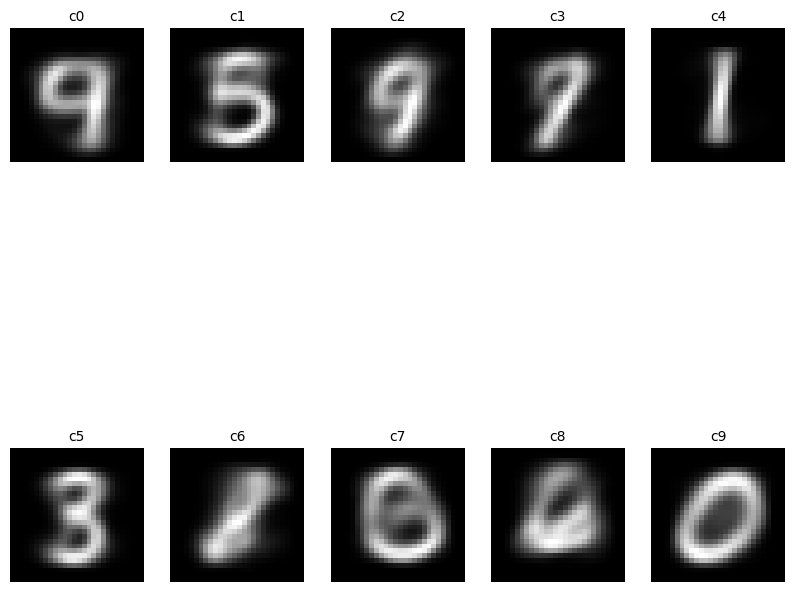

In [9]:
%matplotlib inline

list_images = [c.reshape((28,28)) for c in result.state.global_model_weights]
list_titles = ['c' + str(i) for i in range(0,10)]

fig, axes = plt.subplots(2, 5, figsize=(10, 10))
list_axes = list(axes.flat)
for i in range(len(list_images)):
    list_axes[i].imshow(list_images[i], cmap='gray')
    list_axes[i].set_title(list_titles[i], fontsize=10) 
    list_axes[i].axis('off')

## Comparison versus centralized k-means

In the following cells, the traditional centralized k-means is executed, so the centroids of the previous image can be compared against a typical k-means execution where all the data is together.

In [10]:
# Load mnist from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess data
X = x_train.reshape(len(x_train),-1)
Y = y_train
X = X.astype(float) / 255.

In [11]:
# Initialize KMeans model
kmeans = MiniBatchKMeans(
    n_clusters = 10,
    n_init=1,
    max_iter=NUM_ROUNDS,
)

# Fit the model to the training data
kmeans.fit(X)

MiniBatchKMeans(max_iter=10, n_clusters=10, n_init=1)

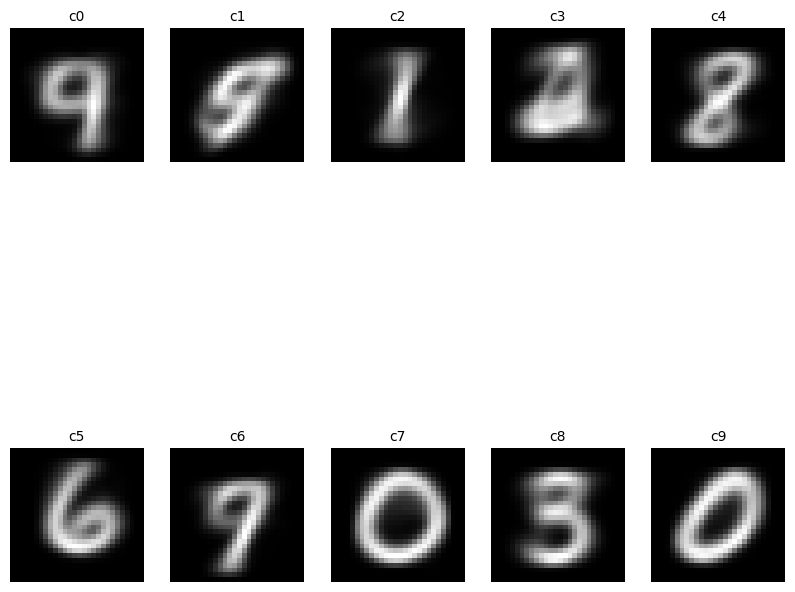

In [12]:
# Plot centroids
%matplotlib inline

list_images = [c.reshape((28,28)) for c in kmeans.cluster_centers_]
list_titles = ['c' + str(i) for i in range(0,10)]

fig, axes = plt.subplots(2, 5, figsize=(10, 10))
list_axes = list(axes.flat)
for i in range(len(list_images)):
    list_axes[i].imshow(list_images[i], cmap='gray')
    list_axes[i].set_title(list_titles[i], fontsize=10) 
    list_axes[i].axis('off')